<a href="https://colab.research.google.com/github/Nimanoro/Finite-state-machine/blob/main/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from PIL import Image, ImageDraw
import numpy as np
import random
import os.path
import pickle
from IPython.display import display

# Modified by Rayat, Jan 2024 to make it compatible with jupyter notebook.
def ComputeSSD(TODOPatch, TODOMask, textureIm, patchL):
	patch_rows, patch_cols, patch_bands = np.shape(TODOPatch)
	tex_rows, tex_cols, tex_bands = np.shape(textureIm)
	ssd_rows = tex_rows - 2 * patchL
	ssd_cols = tex_cols - 2 * patchL
	SSD = np.zeros((ssd_rows,ssd_cols))
	for r in range(ssd_rows):
		for c in range(ssd_cols):
			# Compute sum square difference between textureIm and TODOPatch
			# for all pixels where TODOMask = 0, and store the result in SSD
			#
			# ADD YOUR CODE HERE
			current_patch = textureIm[r:r+patch_rows, c:c+patch_cols, :]

			# Compute the SSD only for pixels where TODOMask is 0
			difference = (current_patch - TODOPatch) ** 2 * 1.0
			ssd_value = np.sum(difference[TODOMask == 0]) * 1.0

			# Store the result in the SSD array
			SSD[r, c] = ssd_value
	return SSD

def CopyPatch(imHole, TODOMask, textureIm, iPatchCenter, jPatchCenter, iMatchCenter, jMatchCenter, patchL):
    patchSize = 2 * patchL + 1
    for i in range(patchSize):
        for j in range(patchSize):
            if TODOMask[i, j] == 1:
                imHole[iPatchCenter - patchL + i, jPatchCenter - patchL + j, :] = \
                    textureIm[iMatchCenter - patchL + i, jMatchCenter - patchL + j, :]
    return imHole

def DrawBox(im,x1,y1,x2,y2):
	draw = ImageDraw.Draw(im)
	draw.line((x1,y1,x1,y2),fill="white",width=1)
	draw.line((x1,y1,x2,y1),fill="white",width=1)
	draw.line((x2,y2,x1,y2),fill="white",width=1)
	draw.line((x2,y2,x2,y1),fill="white",width=1)
	del draw
	return im

def Find_Edge(hole_mask):
	[cols, rows] = np.shape(hole_mask)
	edge_mask = np.zeros(np.shape(hole_mask))
	for y in range(rows):
		for x in range(cols):
			if (hole_mask[x,y] == 1):
				if (hole_mask[x-1,y] == 0 or
						hole_mask[x+1,y] == 0 or
						hole_mask[x,y-1] == 0 or
						hole_mask[x,y+1] == 0):
					edge_mask[x,y] = 1
	return edge_mask


##############################################################################
#                           Main script starts here                          #
##############################################################################

#
# Constants
#

# Change patchL to change the patch size used (patch size is 2 *patchL + 1)
patchL = 10
patchSize = 2*patchL+1

# Standard deviation for random patch selection
randomPatchSD = 1

# Display results interactively
#
# Read input image
#

im = Image.open('donkey.jpg').convert('RGB')
im_array = np.asarray(im, dtype=np.uint8)
imRows, imCols, imBands = np.shape(im_array)

#
# Define hole and texture regions.  This will use files fill_region.pkl and
#   texture_region.pkl, if both exist, otherwise user has to select the regions.
if os.path.isfile('fill_region.pkl') and os.path.isfile('texture_region.pkl'):
	fill_region_file = open('fill_region.pkl', 'rb')
	fillRegion = pickle.load( fill_region_file )
	fill_region_file.close()

	texture_region_file = open('texture_region.pkl', 'rb')
	textureRegion = pickle.load( texture_region_file )
	texture_region_file.close()
else:
	# ask the user to define the regions
	print("Specify the fill and texture regions using polyselect.py")
	exit()

#
# Get coordinates for hole and texture regions
#

fill_indices = fillRegion.nonzero()
nFill = len(fill_indices[0])                # number of pixels to be filled
iFillMax = max(fill_indices[0])
iFillMin = min(fill_indices[0])
jFillMax = max(fill_indices[1])
jFillMin = min(fill_indices[1])
assert((iFillMin >= patchL) and
		(iFillMax < imRows - patchL) and
		(jFillMin >= patchL) and
		(jFillMax < imCols - patchL)) , "Hole is too close to edge of image for this patch size"

texture_indices = textureRegion.nonzero()
iTextureMax = max(texture_indices[0])
iTextureMin = min(texture_indices[0])
jTextureMax = max(texture_indices[1])
jTextureMin = min(texture_indices[1])
textureIm   = im_array[iTextureMin:iTextureMax+1, jTextureMin:jTextureMax+1, :]
texImRows, texImCols, texImBands = np.shape(textureIm)
assert((texImRows > patchSize) and
		(texImCols > patchSize)) , "Texture image is smaller than patch size"

#
# Initialize imHole for texture synthesis (i.e., set fill pixels to 0)
#

imHole = im_array.copy()
imHole[fill_indices] = 0
showResults = True
#
# Is the user happy with fillRegion and textureIm?
#
if showResults == True:
	# original
	#im.show()
	display(im)
	# convert to a PIL image, show fillRegion and draw a box around textureIm
	im1 = Image.fromarray(imHole).convert('RGB')
	im1 = DrawBox(im1,jTextureMin,iTextureMin,jTextureMax,iTextureMax)
	display(im1)
	#im1.show()
	print("Are you happy with this choice of fillRegion and textureIm?")
	Yes_or_No = False
	while not Yes_or_No:
		answer = input("Yes or No: ")
		if answer == "Yes" or answer == "No":
			Yes_or_No = True
	assert answer == "Yes", "You must be happy. Please try again."

#
# Perform the hole filling
#

while (nFill > 0):
	print("Number of pixels remaining = " , nFill)

	# Set TODORegion to pixels on the boundary of the current fillRegion
	TODORegion = Find_Edge(fillRegion)
	edge_pixels = TODORegion.nonzero()
	nTODO = len(edge_pixels[0])

	while(nTODO > 0):

		# Pick a random pixel from the TODORegion
		index = np.random.randint(0,nTODO)
		iPatchCenter = edge_pixels[0][index]
		jPatchCenter = edge_pixels[1][index]

		# Define the coordinates for the TODOPatch
		TODOPatch = imHole[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1,:]
		TODOMask = fillRegion[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1]

		#
		# Compute masked SSD of TODOPatch and textureIm
		#
		ssdIm = ComputeSSD(TODOPatch, TODOMask, textureIm, patchL)

		# Randomized selection of one of the best texture patches
		ssdIm1 = np.sort(np.copy(ssdIm),axis=None)
		ssdValue = ssdIm1[min(round(abs(random.gauss(0,randomPatchSD))),np.size(ssdIm1)-1)]
		ssdIndex = np.nonzero(ssdIm==ssdValue)
		iSelectCenter = ssdIndex[0][0]
		jSelectCenter = ssdIndex[1][0]

		# adjust i, j coordinates relative to textureIm
		iSelectCenter = iSelectCenter + patchL
		jSelectCenter = jSelectCenter + patchL
		selectPatch = textureIm[iSelectCenter-patchL:iSelectCenter+patchL+1,jSelectCenter-patchL:jSelectCenter+patchL+1,:]

		#
		# Copy patch into hole
		#
		imHole = CopyPatch(imHole,TODOMask,textureIm,iPatchCenter,jPatchCenter,iSelectCenter,jSelectCenter,patchL)

		# Update TODORegion and fillRegion by removing locations that overlapped the patch
		TODORegion[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1] = 0
		fillRegion[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1] = 0

		edge_pixels = TODORegion.nonzero()
		nTODO = len(edge_pixels[0])

	fill_indices = fillRegion.nonzero()
	nFill = len(fill_indices[0])

#
# Output results
#
if showResults == True:
	display(Image.fromarray(imHole).convert('RGB'))
Image.fromarray(imHole).convert('RGB').save('results.jpg')



In [ ]:
from PIL import Image, ImageDraw
import numpy as np
import random
import os.path
import pickle
from IPython.display import display

# Modified by Rayat, Jan 2024 to make it compatible with jupyter notebook.
def ComputeSSD(TODOPatch, TODOMask, textureIm, patchL):
	patch_rows, patch_cols, patch_bands = np.shape(TODOPatch)
	tex_rows, tex_cols, tex_bands = np.shape(textureIm)
	ssd_rows = tex_rows - 2 * patchL
	ssd_cols = tex_cols - 2 * patchL
	SSD = np.zeros((ssd_rows,ssd_cols))
	for r in range(ssd_rows):
		for c in range(ssd_cols):
			# Compute sum square difference between textureIm and TODOPatch
			# for all pixels where TODOMask = 0, and store the result in SSD
			#
			# ADD YOUR CODE HERE
			current_patch = textureIm[r:r+patch_rows, c:c+patch_cols, :]

			# Compute the SSD only for pixels where TODOMask is 0
			difference = (current_patch - TODOPatch) ** 2 * 1.0
			ssd_value = np.sum(difference[TODOMask == 0]) * 1.0

			# Store the result in the SSD array
			SSD[r, c] = ssd_value
	return SSD

def CopyPatch(imHole, TODOMask, textureIm, iPatchCenter, jPatchCenter, iMatchCenter, jMatchCenter, patchL):
    patchSize = 2 * patchL + 1
    for i in range(patchSize):
        for j in range(patchSize):
            if TODOMask[i, j] == 1:
                imHole[iPatchCenter - patchL + i, jPatchCenter - patchL + j, :] = \
                    textureIm[iMatchCenter - patchL + i, jMatchCenter - patchL + j, :]
    return imHole

def DrawBox(im,x1,y1,x2,y2):
	draw = ImageDraw.Draw(im)
	draw.line((x1,y1,x1,y2),fill="white",width=1)
	draw.line((x1,y1,x2,y1),fill="white",width=1)
	draw.line((x2,y2,x1,y2),fill="white",width=1)
	draw.line((x2,y2,x2,y1),fill="white",width=1)
	del draw
	return im

def Find_Edge(hole_mask):
	[cols, rows] = np.shape(hole_mask)
	edge_mask = np.zeros(np.shape(hole_mask))
	for y in range(rows):
		for x in range(cols):
			if (hole_mask[x,y] == 1):
				if (hole_mask[x-1,y] == 0 or
						hole_mask[x+1,y] == 0 or
						hole_mask[x,y-1] == 0 or
						hole_mask[x,y+1] == 0):
					edge_mask[x,y] = 1
	return edge_mask


##############################################################################
#                           Main script starts here                          #
##############################################################################

#
# Constants
#

# Change patchL to change the patch size used (patch size is 2 *patchL + 1)
patchL = 10
patchSize = 2*patchL+1

# Standard deviation for random patch selection
randomPatchSD = 1

# Display results interactively
#
# Read input image
#

im = Image.open('donkey.jpg').convert('RGB')
im_array = np.asarray(im, dtype=np.uint8)
imRows, imCols, imBands = np.shape(im_array)

#
# Define hole and texture regions.  This will use files fill_region.pkl and
#   texture_region.pkl, if both exist, otherwise user has to select the regions.
if os.path.isfile('fill_region.pkl') and os.path.isfile('texture_region.pkl'):
	fill_region_file = open('fill_region.pkl', 'rb')
	fillRegion = pickle.load( fill_region_file )
	fill_region_file.close()

	texture_region_file = open('texture_region.pkl', 'rb')
	textureRegion = pickle.load( texture_region_file )
	texture_region_file.close()
else:
	# ask the user to define the regions
	print("Specify the fill and texture regions using polyselect.py")
	exit()

#
# Get coordinates for hole and texture regions
#

fill_indices = fillRegion.nonzero()
nFill = len(fill_indices[0])                # number of pixels to be filled
iFillMax = max(fill_indices[0])
iFillMin = min(fill_indices[0])
jFillMax = max(fill_indices[1])
jFillMin = min(fill_indices[1])
assert((iFillMin >= patchL) and
		(iFillMax < imRows - patchL) and
		(jFillMin >= patchL) and
		(jFillMax < imCols - patchL)) , "Hole is too close to edge of image for this patch size"

texture_indices = textureRegion.nonzero()
iTextureMax = max(texture_indices[0])
iTextureMin = min(texture_indices[0])
jTextureMax = max(texture_indices[1])
jTextureMin = min(texture_indices[1])
textureIm   = im_array[iTextureMin:iTextureMax+1, jTextureMin:jTextureMax+1, :]
texImRows, texImCols, texImBands = np.shape(textureIm)
assert((texImRows > patchSize) and
		(texImCols > patchSize)) , "Texture image is smaller than patch size"

#
# Initialize imHole for texture synthesis (i.e., set fill pixels to 0)
#

imHole = im_array.copy()
imHole[fill_indices] = 0
showResults = True
#
# Is the user happy with fillRegion and textureIm?
#
if showResults == True:
	# original
	#im.show()
	display(im)
	# convert to a PIL image, show fillRegion and draw a box around textureIm
	im1 = Image.fromarray(imHole).convert('RGB')
	im1 = DrawBox(im1,jTextureMin,iTextureMin,jTextureMax,iTextureMax)
	display(im1)
	#im1.show()
	print("Are you happy with this choice of fillRegion and textureIm?")
	Yes_or_No = False
	while not Yes_or_No:
		answer = input("Yes or No: ")
		if answer == "Yes" or answer == "No":
			Yes_or_No = True
	assert answer == "Yes", "You must be happy. Please try again."

#
# Perform the hole filling
#

while (nFill > 0):
	print("Number of pixels remaining = " , nFill)

	# Set TODORegion to pixels on the boundary of the current fillRegion
	TODORegion = Find_Edge(fillRegion)
	edge_pixels = TODORegion.nonzero()
	nTODO = len(edge_pixels[0])

	while(nTODO > 0):

		# Pick a random pixel from the TODORegion
		index = np.random.randint(0,nTODO)
		iPatchCenter = edge_pixels[0][index]
		jPatchCenter = edge_pixels[1][index]

		# Define the coordinates for the TODOPatch
		TODOPatch = imHole[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1,:]
		TODOMask = fillRegion[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1]

		#
		# Compute masked SSD of TODOPatch and textureIm
		#
		ssdIm = ComputeSSD(TODOPatch, TODOMask, textureIm, patchL)

		# Randomized selection of one of the best texture patches
		ssdIm1 = np.sort(np.copy(ssdIm),axis=None)
		ssdValue = ssdIm1[min(round(abs(random.gauss(0,randomPatchSD))),np.size(ssdIm1)-1)]
		ssdIndex = np.nonzero(ssdIm==ssdValue)
		iSelectCenter = ssdIndex[0][0]
		jSelectCenter = ssdIndex[1][0]

		# adjust i, j coordinates relative to textureIm
		iSelectCenter = iSelectCenter + patchL
		jSelectCenter = jSelectCenter + patchL
		selectPatch = textureIm[iSelectCenter-patchL:iSelectCenter+patchL+1,jSelectCenter-patchL:jSelectCenter+patchL+1,:]

		#
		# Copy patch into hole
		#
		imHole = CopyPatch(imHole,TODOMask,textureIm,iPatchCenter,jPatchCenter,iSelectCenter,jSelectCenter,patchL)

		# Update TODORegion and fillRegion by removing locations that overlapped the patch
		TODORegion[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1] = 0
		fillRegion[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1] = 0

		edge_pixels = TODORegion.nonzero()
		nTODO = len(edge_pixels[0])

	fill_indices = fillRegion.nonzero()
	nFill = len(fill_indices[0])

#
# Output results
#
if showResults == True:
	display(Image.fromarray(imHole).convert('RGB'))
Image.fromarray(imHole).convert('RGB').save('results.jpg')



In [ ]:
from PIL import Image, ImageDraw
import numpy as np
import random
import os.path
import pickle
from IPython.display import display

# Modified by Rayat, Jan 2024 to make it compatible with jupyter notebook.
def ComputeSSD(TODOPatch, TODOMask, textureIm, patchL):
	patch_rows, patch_cols, patch_bands = np.shape(TODOPatch)
	tex_rows, tex_cols, tex_bands = np.shape(textureIm)
	ssd_rows = tex_rows - 2 * patchL
	ssd_cols = tex_cols - 2 * patchL
	SSD = np.zeros((ssd_rows,ssd_cols))
	for r in range(ssd_rows):
		for c in range(ssd_cols):
			# Compute sum square difference between textureIm and TODOPatch
			# for all pixels where TODOMask = 0, and store the result in SSD
			#
			# ADD YOUR CODE HERE
			current_patch = textureIm[r:r+patch_rows, c:c+patch_cols, :]

			# Compute the SSD only for pixels where TODOMask is 0
			difference = (current_patch - TODOPatch) ** 2 * 1.0
			ssd_value = np.sum(difference[TODOMask == 0]) * 1.0

			# Store the result in the SSD array
			SSD[r, c] = ssd_value
	return SSD

def CopyPatch(imHole, TODOMask, textureIm, iPatchCenter, jPatchCenter, iMatchCenter, jMatchCenter, patchL):
    patchSize = 2 * patchL + 1
    for i in range(patchSize):
        for j in range(patchSize):
            if TODOMask[i, j] == 1:
                imHole[iPatchCenter - patchL + i, jPatchCenter - patchL + j, :] = \
                    textureIm[iMatchCenter - patchL + i, jMatchCenter - patchL + j, :]
    return imHole

def DrawBox(im,x1,y1,x2,y2):
	draw = ImageDraw.Draw(im)
	draw.line((x1,y1,x1,y2),fill="white",width=1)
	draw.line((x1,y1,x2,y1),fill="white",width=1)
	draw.line((x2,y2,x1,y2),fill="white",width=1)
	draw.line((x2,y2,x2,y1),fill="white",width=1)
	del draw
	return im

def Find_Edge(hole_mask):
	[cols, rows] = np.shape(hole_mask)
	edge_mask = np.zeros(np.shape(hole_mask))
	for y in range(rows):
		for x in range(cols):
			if (hole_mask[x,y] == 1):
				if (hole_mask[x-1,y] == 0 or
						hole_mask[x+1,y] == 0 or
						hole_mask[x,y-1] == 0 or
						hole_mask[x,y+1] == 0):
					edge_mask[x,y] = 1
	return edge_mask


##############################################################################
#                           Main script starts here                          #
##############################################################################

#
# Constants
#

# Change patchL to change the patch size used (patch size is 2 *patchL + 1)
patchL = 10
patchSize = 2*patchL+1

# Standard deviation for random patch selection
randomPatchSD = 1

# Display results interactively
#
# Read input image
#

im = Image.open('donkey.jpg').convert('RGB')
im_array = np.asarray(im, dtype=np.uint8)
imRows, imCols, imBands = np.shape(im_array)

#
# Define hole and texture regions.  This will use files fill_region.pkl and
#   texture_region.pkl, if both exist, otherwise user has to select the regions.
if os.path.isfile('fill_region.pkl') and os.path.isfile('texture_region.pkl'):
	fill_region_file = open('fill_region.pkl', 'rb')
	fillRegion = pickle.load( fill_region_file )
	fill_region_file.close()

	texture_region_file = open('texture_region.pkl', 'rb')
	textureRegion = pickle.load( texture_region_file )
	texture_region_file.close()
else:
	# ask the user to define the regions
	print("Specify the fill and texture regions using polyselect.py")
	exit()

#
# Get coordinates for hole and texture regions
#

fill_indices = fillRegion.nonzero()
nFill = len(fill_indices[0])                # number of pixels to be filled
iFillMax = max(fill_indices[0])
iFillMin = min(fill_indices[0])
jFillMax = max(fill_indices[1])
jFillMin = min(fill_indices[1])
assert((iFillMin >= patchL) and
		(iFillMax < imRows - patchL) and
		(jFillMin >= patchL) and
		(jFillMax < imCols - patchL)) , "Hole is too close to edge of image for this patch size"

texture_indices = textureRegion.nonzero()
iTextureMax = max(texture_indices[0])
iTextureMin = min(texture_indices[0])
jTextureMax = max(texture_indices[1])
jTextureMin = min(texture_indices[1])
textureIm   = im_array[iTextureMin:iTextureMax+1, jTextureMin:jTextureMax+1, :]
texImRows, texImCols, texImBands = np.shape(textureIm)
assert((texImRows > patchSize) and
		(texImCols > patchSize)) , "Texture image is smaller than patch size"

#
# Initialize imHole for texture synthesis (i.e., set fill pixels to 0)
#

imHole = im_array.copy()
imHole[fill_indices] = 0
showResults = True
#
# Is the user happy with fillRegion and textureIm?
#
if showResults == True:
	# original
	#im.show()
	display(im)
	# convert to a PIL image, show fillRegion and draw a box around textureIm
	im1 = Image.fromarray(imHole).convert('RGB')
	im1 = DrawBox(im1,jTextureMin,iTextureMin,jTextureMax,iTextureMax)
	display(im1)
	#im1.show()
	print("Are you happy with this choice of fillRegion and textureIm?")
	Yes_or_No = False
	while not Yes_or_No:
		answer = input("Yes or No: ")
		if answer == "Yes" or answer == "No":
			Yes_or_No = True
	assert answer == "Yes", "You must be happy. Please try again."

#
# Perform the hole filling
#

while (nFill > 0):
	print("Number of pixels remaining = " , nFill)

	# Set TODORegion to pixels on the boundary of the current fillRegion
	TODORegion = Find_Edge(fillRegion)
	edge_pixels = TODORegion.nonzero()
	nTODO = len(edge_pixels[0])

	while(nTODO > 0):

		# Pick a random pixel from the TODORegion
		index = np.random.randint(0,nTODO)
		iPatchCenter = edge_pixels[0][index]
		jPatchCenter = edge_pixels[1][index]

		# Define the coordinates for the TODOPatch
		TODOPatch = imHole[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1,:]
		TODOMask = fillRegion[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1]

		#
		# Compute masked SSD of TODOPatch and textureIm
		#
		ssdIm = ComputeSSD(TODOPatch, TODOMask, textureIm, patchL)

		# Randomized selection of one of the best texture patches
		ssdIm1 = np.sort(np.copy(ssdIm),axis=None)
		ssdValue = ssdIm1[min(round(abs(random.gauss(0,randomPatchSD))),np.size(ssdIm1)-1)]
		ssdIndex = np.nonzero(ssdIm==ssdValue)
		iSelectCenter = ssdIndex[0][0]
		jSelectCenter = ssdIndex[1][0]

		# adjust i, j coordinates relative to textureIm
		iSelectCenter = iSelectCenter + patchL
		jSelectCenter = jSelectCenter + patchL
		selectPatch = textureIm[iSelectCenter-patchL:iSelectCenter+patchL+1,jSelectCenter-patchL:jSelectCenter+patchL+1,:]

		#
		# Copy patch into hole
		#
		imHole = CopyPatch(imHole,TODOMask,textureIm,iPatchCenter,jPatchCenter,iSelectCenter,jSelectCenter,patchL)

		# Update TODORegion and fillRegion by removing locations that overlapped the patch
		TODORegion[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1] = 0
		fillRegion[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1] = 0

		edge_pixels = TODORegion.nonzero()
		nTODO = len(edge_pixels[0])

	fill_indices = fillRegion.nonzero()
	nFill = len(fill_indices[0])

#
# Output results
#
if showResults == True:
	display(Image.fromarray(imHole).convert('RGB'))
Image.fromarray(imHole).convert('RGB').save('results.jpg')



#Run the Holefill.py file.

First copy the contents of assign_Notebook into the project directory. In order to run the Holefill.py from notebook, execute the command below. It will print two figures inline: one containing the orginal image and the other showing the region to be filled and the texture region. You will be asked, Are you happy with this choice of fillRegion and textureIm? Type Yes to proceeed. Finally, the script will print a figure of the image with the texture filled in. As this skeleton program is missing some critical routines, the texture will initially be filled in as all black.

# Modify Holefill.py

You need to modify a function `ComputeSSD` in Holefill.py that computes the sum squared difference (SSD) between an image patch and the texture image, for each possible location of the patch within the texture image.  It must ignore empty pixels that have a value of 1 in the given mask image. Look at the Hints Provided in the main Assignment instruction.

 For next part, you need to modify the function `CopyPatch` in the 'Holefill.py' that takes the SSD image created above and chooses randomly amongst the best matching patches to decide which patch to paste into the texture image at that point. Remember again that you should only copy pixel values into the hole section of the image. Existing pixel values should not be overwritten. Skeleton code for `CopyPatch` is provided in `Holefill.py`, along with comments explaining the arguments.

 Try running the 'Holefill.py' again with the modified code to see if hole-filling part is correctly implemented.

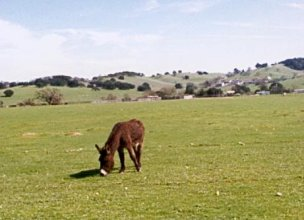

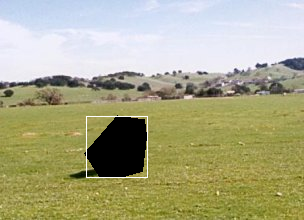

Are you happy with this choice of fillRegion and textureIm?
Yes or No: Yes
Number of pixels remaining =  2846
Number of pixels remaining =  1019
Number of pixels remaining =  36


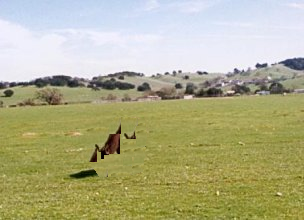

In [19]:
%run Holefill.py

#Custom fill and texture Regions

Now you can select your own regions to fill or texture selection by running the polyselect.py function. To make interactive inline operations compatible with jupyter notebook, you need to first install 'ipympl' using 'pip install ipympl'. Then you need to enable the inline interactive operation by '%matplotlib ipympl' Finally execute the polyselect.py file using '%run polyselect.py'

In [ ]:
!pip install ipympl



In [11]:
%matplotlib ipympl

Now run the polyselect.py file. To draw a polygon you need to select each successive vertex with a  left-click. Simply right-click anywhere in the image to save the polygon. When you run the 'polyselect.py' file you will be prompted whether you want to draw polygon for fill region (type '0') or texture region (type '1'). Depending on what you choose the polyon will be saved in either 'fill_region.pkl' or 'texture_region.pkl' To run the polyselect execute the following:

Would you like to select the region to be filled (0) or the sample texture region (1)?
0 or 1: 0
Please use your mouse to specify the region that you want for fill_region.pkl
(Left-click to select each polygon vertex. Right-click to finalize and save the polygon.)


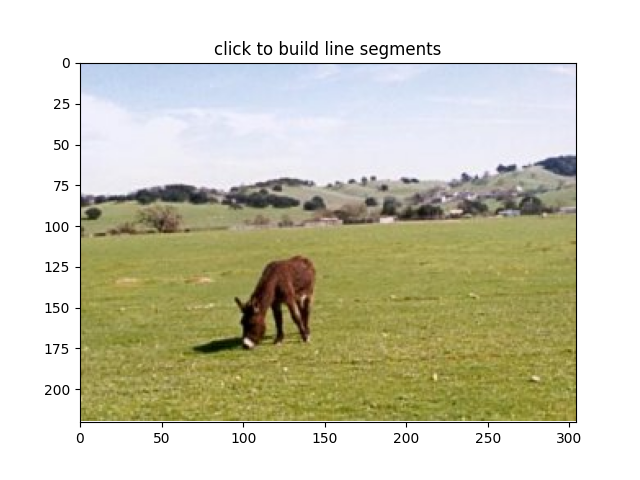

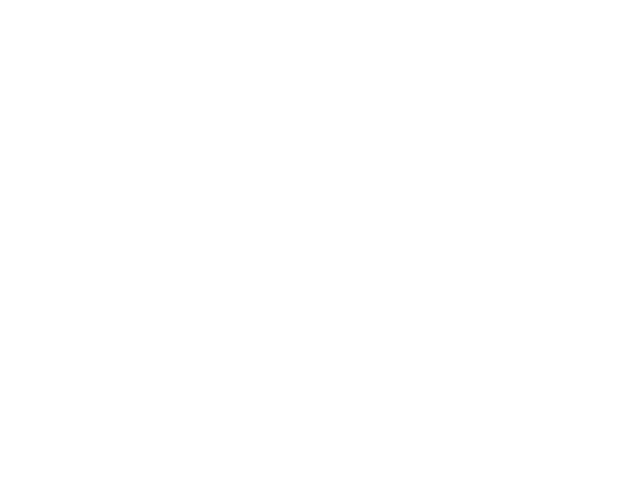

Saved region to fill_region.pkl!


In [17]:
%run polyselect.py